## Chapter 3 - Time Series Decomposition


In [88]:
import polars as pl 
import numpy as np
import os
from dotenv import load_dotenv
from matplotlib import pyplot as plt
import seaborn as sns
from lets_plot import *
from statsmodels.tsa.seasonal import STL
LetsPlot.setup_html()

pl.Config.set_tbl_rows(100)

# Load environment variables from .env file
load_dotenv()
# Retrieve the dataset path from the environment variable
DATASET = os.getenv('DATASET')
df = pl.read_parquet(DATASET)

df = df.with_columns(
    np.log1p(pl.col('casos')).alias('log_casos'),
    ((pl.col('casos')/pl.col('population')) *100000).alias('dir'),
    np.log1p(((pl.col('casos')/pl.col('population')) *100000)).alias('log_dir'),
)

In [89]:
def colapse_52_53(df):
    temp = df.filter(pl.col('week') == 53)[['epiweek','geocode','casos']].with_columns(
        (pl.col('epiweek')-1).alias('epiweek')
    )
    
    df = df.join(temp,on=['geocode','epiweek'],how='left').with_columns(
        pl.when(pl.col('casos_right').is_null())
        .then(pl.col('casos'))
        .otherwise(pl.col('casos_right') + pl.col('casos'))
        .alias('casos')
    ).drop('casos_right')

    df = df.filter(pl.col('week') < 53)
    return df

In [90]:
df = colapse_52_53(df)

In [91]:
# Aggregate
def agg_dengue(df,group=''):
    if group == '':
        cols = ['date','epiweek','week','year']
    else:
        cols = ['date','epiweek','week','year',group]
    gdf = df.group_by(cols).agg(
        pl.col('casos').sum().alias('casos'),
        pl.col('population').mean().alias('population'),
        pl.col('outlier').first().alias('outlier'),
    ).sort('year')
    
    gdf = gdf.with_columns(
        ((pl.col('casos')/pl.col('population')) *100000).alias('dir'),
        np.log1p(pl.col('casos')).alias('log_casos'),
        np.log1p(((pl.col('casos')/pl.col('population')) *100000)).alias('log_dir'),
    )
    return gdf
gdf = agg_dengue(df)

In [92]:
gdf = gdf.with_columns(
    pl.when(pl.col('week') < 41)
    .then(
        (pl.col('year')-1).cast(pl.Utf8) + '-' + pl.col('year').cast(pl.Utf8)
    )
    .otherwise(
        pl.col('year').cast(pl.Utf8) +'-' + (pl.col('year')+1).cast(pl.Utf8)
    )
    .alias('season')
)

gdf = gdf.with_columns(
    pl.when(pl.col('week') < 41)
    .then(
        # pl.col('week') + 12
        pl.when(pl.col('year').is_in([2013,2021]))
        .then(pl.col('week') + 12)
        .otherwise(pl.col('week') + 11)
    )
    .otherwise(
        (pl.col('week') - 41)
    )
    .alias('season_week')
)
gdf = gdf.sort('date')

<Axes: xlabel='date', ylabel='log_casos'>

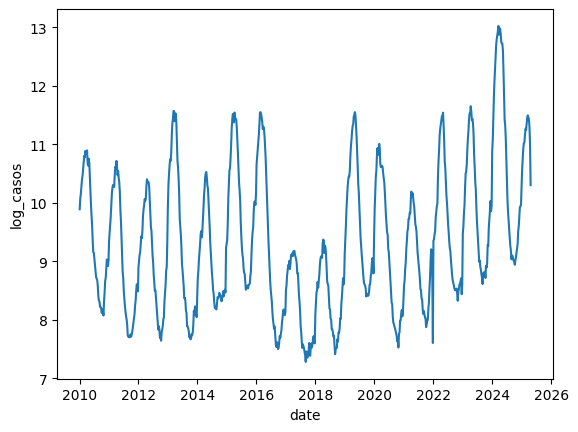

In [93]:
sns.lineplot(data=gdf,x='date',y='log_casos')

### Rolling Mean



In [ ]:
# using pandas

plt.plot(gdf.to_pandas()['log_casos'].rolling(window=52, center=True).mean())

<Axes: xlabel='date', ylabel='log_casos'>

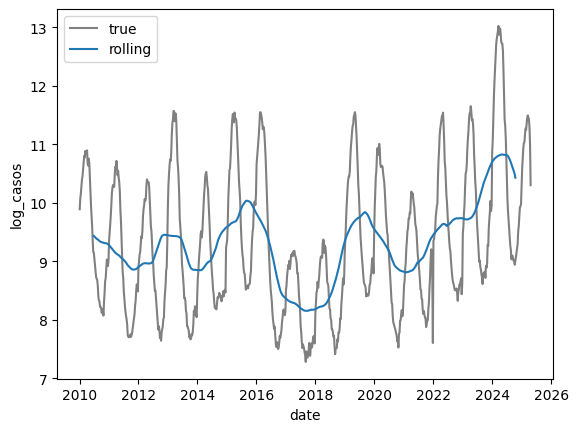

In [107]:
# the equivalent, but using Polars
window_size = 52

gdf = gdf.with_columns(
    pl.col("log_casos")
    .rolling_mean(window_size)
    .shift(-(window_size // 2))
    .alias("log_casos_rolling_mean")
)



sns.lineplot(data=gdf, x = 'date', y = 'log_casos',color='grey',label='true')
sns.lineplot(data=gdf, x = 'date', y = 'log_casos_rolling_mean', label='rolling')

## STL
STL is a versatile and robust method for decomposing time series. STL is an acronym for “Seasonal and Trend decomposition using Loess”, while loess is a method for estimating nonlinear relationships. 
STL is a versatile and robust method for decomposing time series. STL is an acronym for “Seasonal and Trend decomposition using Loess”, while loess is a method for estimating nonlinear relationships. 

<Axes: xlabel='date', ylabel='log_casos'>

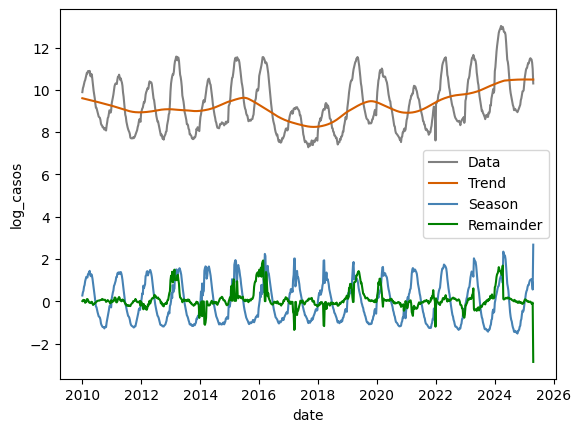

In [68]:
stl = STL(gdf["log_casos"], period=52,robust=True)
res = stl.fit()

gdf = gdf.with_columns(
    pl.Series(name="seasonal", values=res.seasonal),
    pl.Series(name="trend", values=res.trend),
    pl.Series(name="remainder", values=res.resid),
)

sns.lineplot(data=gdf, x="date", y="log_casos", label="Data", color="gray")
sns.lineplot(data=gdf, x="date", y="trend", label="Trend", color="#D55E00")
sns.lineplot(data=gdf, x="date", y="seasonal", label="Season", color="steelblue")
sns.lineplot(data=gdf, x="date", y="remainder", label="Remainder", color="green")